In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *
import networkx as nx

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE


In [3]:
from itertools import product

dimensions = [3,5,10]
incoming_edges = [2, 3, 4]
taus = [5, 10, 15, 20]
autocorrs = [False, True]
data_length = [10000]
runs = range(10)

setups = list(product(dimensions, incoming_edges, taus, autocorrs, data_length, runs))

# Experiment 4

In [ ]:
import pickle


def graph2Var(graph, dim, tau, mapping):
    inverted_mapping = {v: k for k, v in mapping.items()}
    params = np.zeros((dim * tau, dim))

    for x_t in range(dim):
        input_nodes = list(graph.predecessors(mapping[x_t]))
        inputs = np.array([inverted_mapping[x] for x in input_nodes])
        for i in inputs:
            params[i - dim, x_t] = graph.edges[(mapping[i], mapping[x_t])]['weight']
    return params

data_path = 'notebooks/ICML/nonstationary_data/'
results_path = 'notebooks/ICML/icml_results_nonstationary/'
results = pd.DataFrame()

names = ['PC1 incremental', 'PC extensive', 'PC incremental', 'PCMCI incremental']

for dim, in_edges, tau, autocorr, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    algo_graphs = pickle.load(open(results_path + 'exp3_graphs/' + 
                                   f'graphs-t={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    max_tau = 2*tau
    df_dict = {'dimension': [dim]*max_tau, 'max time lag': [tau]*max_tau, 'incoming edges': [in_edges]*max_tau, 
               'run': [run]*max_tau, 'autocorr': [autocorr]*max_tau, 'tau estimate': list(range(1, max_tau+1))}
    
    true_mapping, true_matrix = transform_ts(generator.ts, tau)
    true_params = graph2Var(generator.graph, dim, tau, true_mapping)
    
    # each algorithm
    for name in names:
        df_dict[name+' - MSE full'] = []
        df_dict[name+' - MSE TR'] = []
        df_dict[name+' - MSE FP'] = []
        graphs = algo_graphs[name]
        
        assert len(graphs) == max_tau
        for est_tau, graph in graphs.items():
            model = VAR(est_tau)
            node_mapping, data_matrix = transform_ts(generator.ts, est_tau)
            model.fit_from_graph(dim, data_matrix, graph, node_mapping)
            est_params = model.params[1:]
            mse_full, mse_tr, mse_fp = evaluate_parameters(true_params, est_params)
            df_dict[name+' - MSE full'].append(mse_full)
            df_dict[name+' - MSE TR'].append(mse_tr)
            df_dict[name+' - MSE FP'].append(mse_fp)
    
    # VAR for different tau'
    df_dict['complete VAR - MSE full'] = []
    df_dict['complete VAR - MSE TR'] = []
    df_dict['complete VAR - MSE FP'] = []
    for est_tau in range(1, max_tau+1):
        model = VAR(est_tau)
        model.fit(generator.ts)
        est_params = model.params[1:]
        mse_full, mse_tr, mse_fp = evaluate_parameters(true_params, est_params)
        df_dict['complete VAR - MSE full'].append(mse_full)
        df_dict['complete VAR - MSE TR'].append(mse_tr)
        df_dict['complete VAR - MSE FP'].append(mse_fp)
    
    # True Graph VAR
    model = VAR(tau)
    model.fit_from_graph(dim, true_matrix, generator.graph, true_mapping)
    est_params = model.params[1:]
    df_dict['true Graph'] = [evaluate_parameters(true_params, est_params)] * max_tau
    
    df = pd.DataFrame(df_dict)
    results = results.append(df)
    
    results.to_csv(results_path + f'experiment4.csv', index=False)
    

/home/Daniel.Thevessen/Causality/CIoTS/CIoTS/evaluation.py:123: RuntimeWarning: Mean of empty slice.
  mse_fp = se[(true_params == 0) & (est_params != 0)].mean()
/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Aggregate experiment4

In [ ]:
results_path = 'notebooks/ICML/icml_results_nonstationary/'

results3 = pd.read_csv(results_path + 'experiment3.csv')
# dim10 not done yet
# results3 = results3[results3.dimension != 10]
results4 = pd.read_csv(results_path + 'experiment4.csv')

names = ['PC1 incremental', 'PC extensive', 'PC incremental', 'PCMCI incremental']
stopper, params = ICStopper, {'patiency': 2}

def simulate_stopping(df, stopping, params, col):
    sorted_df = df.sort_values(by='tau estimate')
    idx = stopping.simulate(sorted_df[col].values, **params)
    return sorted_df['tau estimate'].iloc[idx]

results4_agg = pd.DataFrame()

for (dim, in_edges, tau, autocorr, run), res4 in results4.groupby([
    'dimension', 'incoming edges', 'max time lag', 'autocorr', 'run']):
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'edges': in_edges, 'autocorr': autocorr, 'run': run}
    
    res3 = results3[(results3[['dimension', 'incoming edges', 'max time lag', 'autocorr', 'run'
                                 ]].values == (dim, in_edges, tau, autocorr, run)).all(axis=1)]
    for name in names:
        pred_tau = simulate_stopping(res3, stopper, params, name + '_bics')
        df_dict[name + ' tau estimate'] = pred_tau
        
        for mse_type in [' - MSE full', ' - MSE TR', ' - MSE FP']:
            df_dict[name+mse_type] = res4[res4['tau estimate'] == pred_tau][name + mse_type].iloc[0]
    
    for mse_type in [' - MSE full', ' - MSE TR', ' - MSE FP']:
        df_dict['VAR tau-1'+mse_type] = res4[res4['tau estimate'] == tau-1]['complete VAR' + mse_type].iloc[0]
        df_dict['VAR tau'+mse_type] = res4[res4['tau estimate'] == tau]['complete VAR' + mse_type].iloc[0]
        df_dict['VAR tau+1'+mse_type] = res4[res4['tau estimate'] == tau+1]['complete VAR' + mse_type].iloc[0]

    print(df_dict)
    df = pd.DataFrame(df_dict, index=[0])
    results4_agg = results4_agg.append(df)
    
    results4_agg.to_csv(results_path + f'experiment4_aggregated.csv', index=False)

In [18]:
results4_agg.columns

Index(['dimension', 'max time lag', 'edges', 'autocorr', 'run',
       'PC1 incremental tau estimate', 'PC1 incremental - MSE full',
       'PC1 incremental - MSE TR', 'PC1 incremental - MSE FP',
       'PC extensive tau estimate', 'PC extensive - MSE full',
       'PC extensive - MSE TR', 'PC extensive - MSE FP',
       'PC incremental tau estimate', 'PC incremental - MSE full',
       'PC incremental - MSE TR', 'PC incremental - MSE FP',
       'PCMCI incremental tau estimate', 'PCMCI incremental - MSE full',
       'PCMCI incremental - MSE TR', 'PCMCI incremental - MSE FP',
       'VAR tau-1 - MSE full', 'VAR tau - MSE full', 'VAR tau+1 - MSE full',
       'VAR tau-1 - MSE TR', 'VAR tau - MSE TR', 'VAR tau+1 - MSE TR',
       'VAR tau-1 - MSE FP', 'VAR tau - MSE FP', 'VAR tau+1 - MSE FP'],
      dtype='object')

### Add pure VAR tau estimates

In [ ]:
import pickle

data_path = 'notebooks/ICML/icml_data_nonstationary/'

var_estimates = pd.DataFrame()
for dim, in_edges, tau, autocorr, _, run in setups:
    df_dict = {'dimension': dim, 'max time lag': tau, 'edges': in_edges, 'autocorr': autocorr, 'run': run}
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    max_tau = 2*tau
    
    p_rankings, ic_scores = var_order_select(generator.ts, max_p=max_tau)
    
    df_dict['VAR tau estimate'] = p_rankings['bic'][0] if len(p_rankings['bic']) > 0 else max_tau
    
    var_estimates = var_estimates.append(df_dict, ignore_index=True)
var_estimates

In [ ]:
results_path = 'notebooks/ICML/icml_results_nonstationary/'

results4_agg['VAR tau estimate'] = var_estimates['VAR tau estimate']
results4_agg.to_csv(results_path + f'experiment4_aggregated.csv', index=False)

### Find best PC approach 

In [87]:
pd.DataFrame(*np.unique(results4_agg[['PC incremental - MSE full', 'PC extensive - MSE full', 
              'PC1 incremental - MSE full', 'PCMCI incremental - MSE full', 
              'VAR tau - MSE full']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC extensive - MSE full,43
PC incremental - MSE full,149
PC1 incremental - MSE full,315
PCMCI incremental - MSE full,175
VAR tau - MSE full,38


In [88]:
pd.DataFrame(*np.unique(results4_agg[['PC incremental - MSE TR', 'PC extensive - MSE TR', 
              'PC1 incremental - MSE TR', 'PCMCI incremental - MSE TR',
              'VAR tau - MSE TR']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC extensive - MSE TR,89
PC incremental - MSE TR,183
PC1 incremental - MSE TR,264
PCMCI incremental - MSE TR,84
VAR tau - MSE TR,100


In [89]:
pd.DataFrame(*np.unique(results4_agg[['PC incremental - MSE FP', 'PC extensive - MSE FP', 
              'PC1 incremental - MSE FP', 'PCMCI incremental - MSE FP',
              'VAR tau - MSE full']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC extensive - MSE FP,35
PC incremental - MSE FP,58
PC1 incremental - MSE FP,411
PCMCI incremental - MSE FP,81
VAR tau - MSE full,135


In [102]:
pd.DataFrame(*np.unique(results4_agg[['PC1 incremental - MSE full', 
                                      'VAR tau - MSE full']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC1 incremental - MSE full,646
VAR tau - MSE full,74


In [15]:
results4_agg.median()[['PC incremental - MSE full', 'PC extensive - MSE full', 
              'PC1 incremental - MSE full', 'PCMCI incremental - MSE full', 
              'VAR tau - MSE full']]

PC incremental - MSE full         0.007079
PC extensive - MSE full           0.006767
PC1 incremental - MSE full        0.003646
PCMCI incremental - MSE full      0.005482
VAR tau - MSE full              307.677207
dtype: float64

### misc

In [43]:
df = results4_agg.copy()
df['ratio'] = df['VAR tau - MSE full'] / df['PC1 incremental - MSE full']

In [124]:
means = df.groupby(['dimension', 'max time lag', 'edges']).mean()
(means['VAR tau estimate'] - means['PC1 incremental tau estimate']).mean()

2.041666666666666

In [100]:
np.unique(df.groupby(['dimension', 'edges', 
                      'max time lag', 'autocorr']).mean()['PC1 incremental tau estimate'] > 1,
          return_counts=True)

(array([ True]), array([72]))

In [ ]:
df.groupby(['dimension', 'max time lag', 'edges', 'autocorr']).median()[[
    'VAR', 'PC1 incremental tau estimate']]

## Visualization

In [9]:
results_path = 'notebooks/ICML/icml_results_nonstationary/'
results3 = pd.read_csv(results_path + 'experiment3.csv')
results3 = results3[results3.dimension != 10]
# results3

In [10]:
results4 = pd.read_csv(results_path + 'experiment4.csv')
# results4

In [8]:
len(results4_agg)

720

In [13]:
mse_type = ' - MSE TR'
print(results4_agg.groupby(['dimension', 'edges', 'max time lag']).median()[['VAR tau-1' + mse_type, 
                'VAR tau' + mse_type,
                'VAR tau+1' + mse_type, 
                'PC1 incremental' + mse_type]].to_latex(float_format='%.2E'))

\begin{tabular}{lllrrrr}
\toprule
   &   &    &  VAR tau-1 - MSE TR &  VAR tau - MSE TR &  VAR tau+1 - MSE TR &  PC1 incremental - MSE TR \\
dimension & edges & max time lag &                     &                   &                     &                           \\
\midrule
3  & 2 & 5  &            9.51E-02 &          5.92E-02 &            4.17E-02 &                  5.20E-02 \\
   &   & 10 &            1.38E-01 &          6.28E-02 &            8.12E-02 &                  7.22E-02 \\
   &   & 15 &            2.59E-01 &          2.60E-01 &            3.58E-01 &                  9.29E-02 \\
   &   & 20 &            1.65E-01 &          2.57E-01 &            1.61E+21 &                  1.27E-01 \\
   & 3 & 5  &            9.22E-02 &          3.18E-02 &            7.01E-02 &                  8.31E-02 \\
   &   & 10 &            1.22E-01 &          1.29E-01 &            9.47E-02 &                  6.82E-02 \\
   &   & 15 &            1.23E-01 &          1.36E-01 &            1.12E-01 &   

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


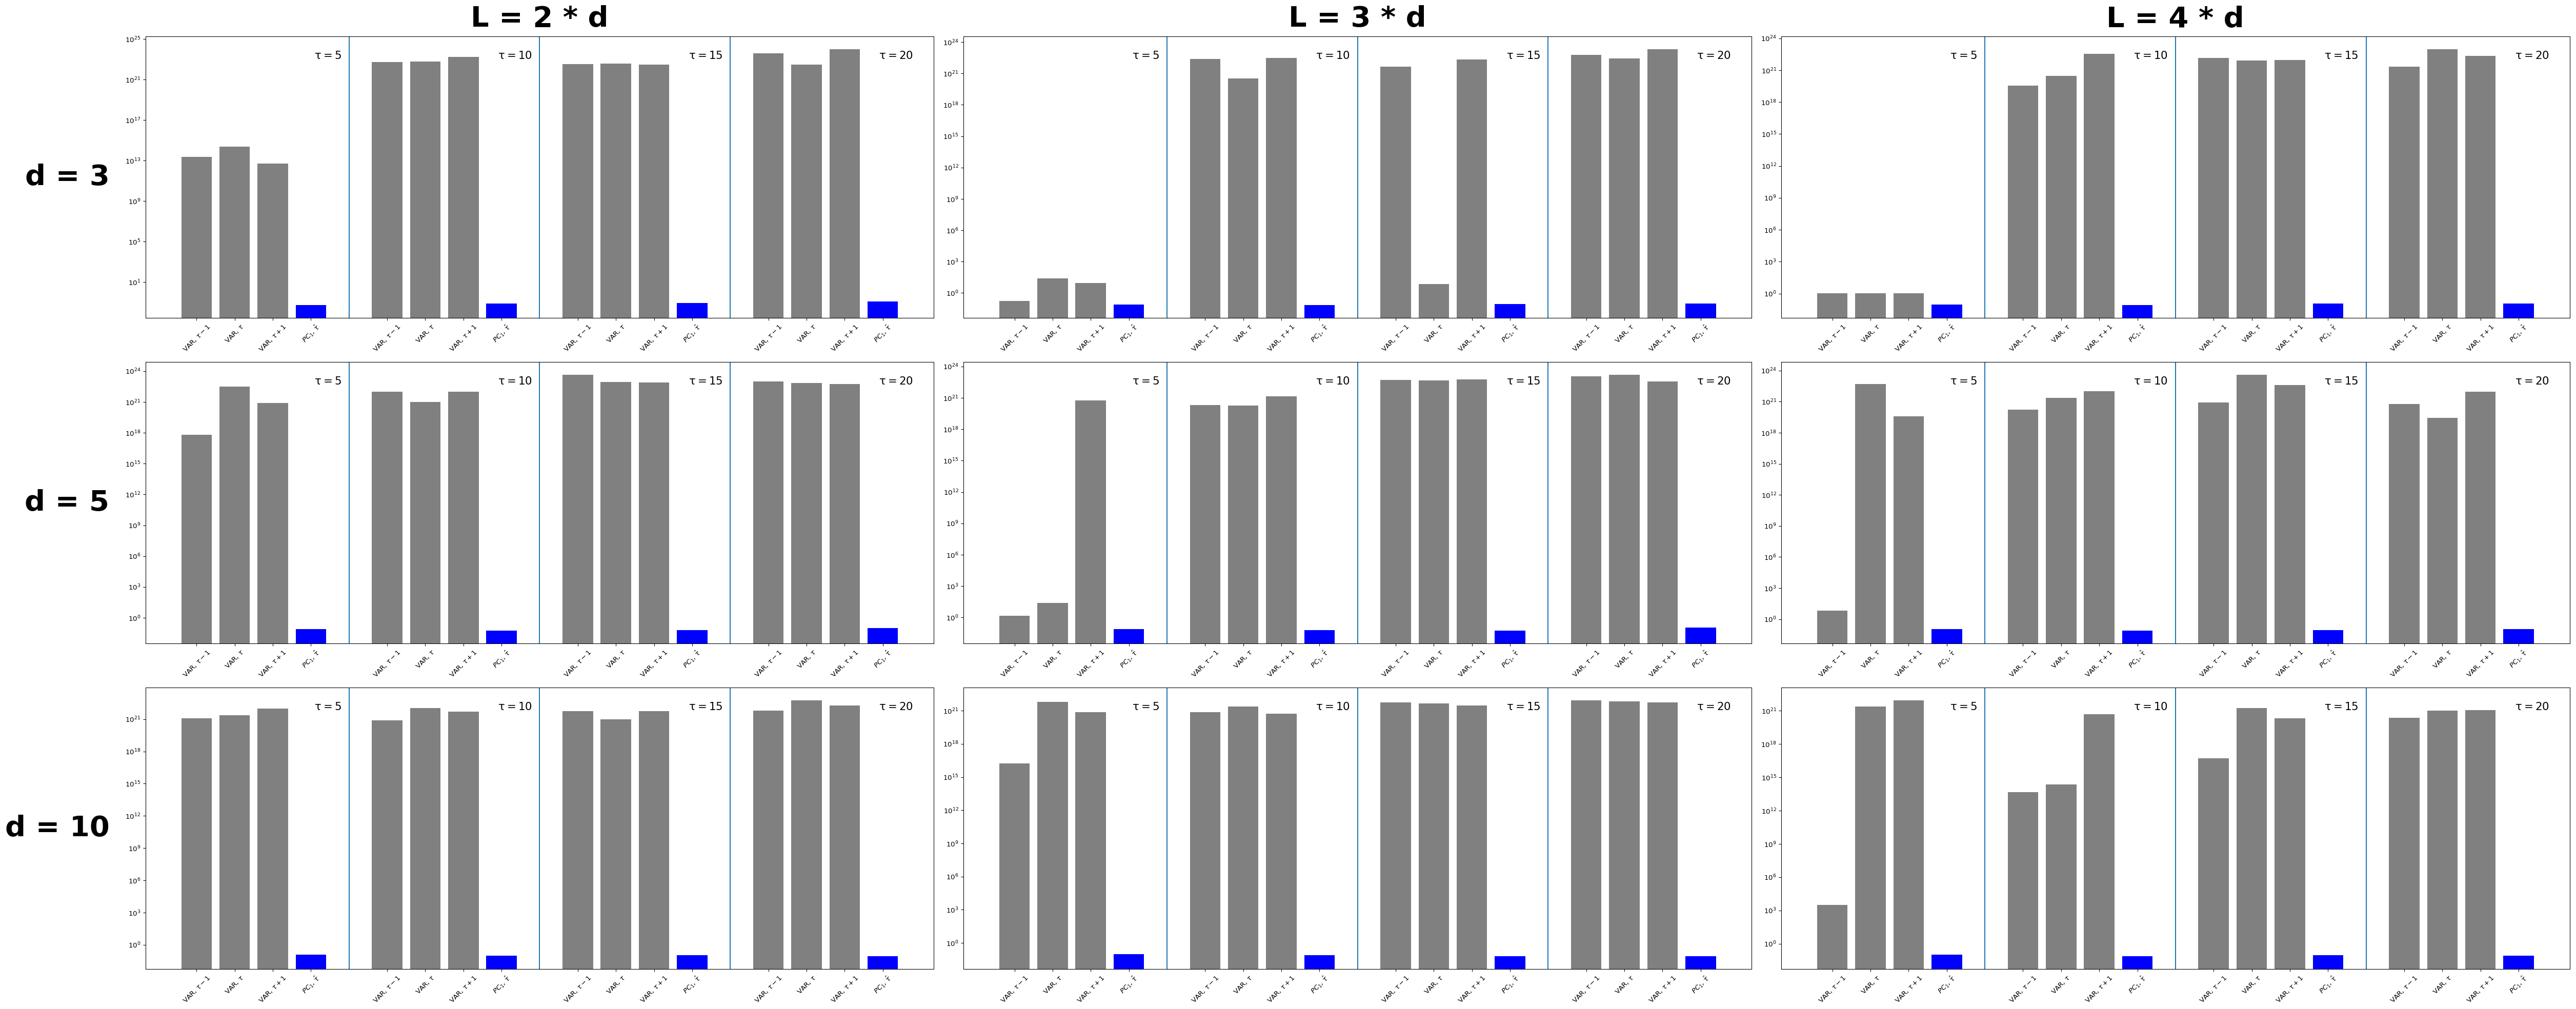

In [12]:
from itertools import product

results_path = 'notebooks/ICML/icml_results_nonstationary/'
results4_agg = pd.read_csv(results_path + 'experiment4_aggregated.csv')
algorithm = 'PC1 incremental'
mse_type = ' - MSE TR'

fig, axes = plt.subplots(len(dimensions), len(incoming_edges), 
                        figsize=(50,20), dpi=96)
for row_idx, dim in enumerate(dimensions):
    for col_idx, in_edges in enumerate(incoming_edges):
        ax = axes[row_idx, col_idx]
        
        cmp_cnt = 4
        all_bar_heights = []
        all_tick_labels = []
        all_colors = []
        for plt_idx, tau in enumerate(taus):
            plt_data = results4_agg[(results4_agg[['dimension', 'edges', 'max time lag'
                                                  ]].values == (dim, in_edges, tau)).all(axis=1)]
            bar_heights = plt_data[[
                'VAR tau-1' + mse_type, 
                'VAR tau' + mse_type,
                'VAR tau+1' + mse_type, 
                algorithm + mse_type
            ]].mean()
            all_bar_heights.extend(bar_heights)
            
            all_colors.extend([
                'grey', 
                'grey', 
                'grey', 
                'blue'
            ])
            all_tick_labels.extend([
                r'VAR, $\tau-1$', 
                r'VAR, $\tau$', 
                r'VAR, $\tau+1$',
#               algorithm + r', $\hat{\tau}$'])
                r'$PC_{1}$, $\hat{\tau}$'
            ])
            ax.annotate(r'$\mathrm{\tau = ' + str(tau) + r'}$', xy=((cmp_cnt+1)*plt_idx + (cmp_cnt - 0.2), 0.95),
                        xycoords=('data', 'axes fraction'), fontsize=16,
                        horizontalalignment='right', va='top')
        
        for sep_idx in np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1):
            ax.axvline(sep_idx)
        ax.bar(np.delete(np.arange((cmp_cnt+1)*len(taus)-1), np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1)),
               height=all_bar_heights, color=all_colors,
               tick_label=all_tick_labels)
        ax.tick_params(axis='x', rotation=45)
        ax.set_yscale('log')
        

pad = 15
for ax, col in zip(axes[0], [f'L = {in_e} * d' for in_e in incoming_edges]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=42, ha='center', va='baseline', fontweight='bold')

for ax, row in zip(axes[:,0], [f'd = {dim}' for dim in dimensions]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=42, ha='right', va='center', fontweight='bold')

plt.tight_layout()
fig.show()

In [15]:
results4_agg.columns

Index(['dimension', 'max time lag', 'edges', 'autocorr', 'run',
       'PC1 incremental tau estimate', 'PC1 incremental - MSE full',
       'PC1 incremental - MSE TR', 'PC1 incremental - MSE FP',
       'PC extensive tau estimate', 'PC extensive - MSE full',
       'PC extensive - MSE TR', 'PC extensive - MSE FP',
       'PC incremental tau estimate', 'PC incremental - MSE full',
       'PC incremental - MSE TR', 'PC incremental - MSE FP',
       'PCMCI incremental tau estimate', 'PCMCI incremental - MSE full',
       'PCMCI incremental - MSE TR', 'PCMCI incremental - MSE FP',
       'VAR tau-1 - MSE full', 'VAR tau - MSE full', 'VAR tau+1 - MSE full',
       'VAR tau-1 - MSE TR', 'VAR tau - MSE TR', 'VAR tau+1 - MSE TR',
       'VAR tau-1 - MSE FP', 'VAR tau - MSE FP', 'VAR tau+1 - MSE FP'],
      dtype='object')

In [37]:
pd.read_csv('notebooks/ICML/icml_results_v2/experiment4_aggregated.csv'
           ).groupby(['max time lag']).mean()['PC1 incremental - MSE TR']

max time lag
5     0.072730
10    0.060316
15    0.048275
20    0.052348
Name: PC1 incremental - MSE TR, dtype: float64

In [36]:
results4_agg.groupby(['max time lag']).mean()['PC1 incremental - MSE TR']

max time lag
5     0.091282
10    0.075103
15    0.084960
20    0.098531
Name: PC1 incremental - MSE TR, dtype: float64

# Experiment 5

In [51]:
data_path = 'notebooks/ICML/icml_data_v2/'
results_path = 'notebooks/ICML/icml_results_v2/'

result5 = pd.read_csv(results_path + 'experiment5.csv')

In [58]:
result5.columns

Index(['PC1 incremental - FDR', 'PC1 incremental - FPR',
       'PC1 incremental - MSE FP', 'PC1 incremental - MSE TR',
       'PC1 incremental - MSE full', 'PC1 incremental - TPR',
       'PC1 incremental - accuracy', 'PC1 incremental - f1-score',
       'PC1 incremental - matthews_corrcoef', 'PC1 incremental - precision',
       'PC1 tau - FDR', 'PC1 tau - FPR', 'PC1 tau - MSE FP',
       'PC1 tau - MSE TR', 'PC1 tau - MSE full', 'PC1 tau - TPR',
       'PC1 tau - accuracy', 'PC1 tau - f1-score',
       'PC1 tau - matthews_corrcoef', 'PC1 tau - precision', 'PC1 tau+1 - FDR',
       'PC1 tau+1 - FPR', 'PC1 tau+1 - MSE FP', 'PC1 tau+1 - MSE TR',
       'PC1 tau+1 - MSE full', 'PC1 tau+1 - TPR', 'PC1 tau+1 - accuracy',
       'PC1 tau+1 - f1-score', 'PC1 tau+1 - matthews_corrcoef',
       'PC1 tau+1 - precision', 'PC1 tau+2 - FDR', 'PC1 tau+2 - FPR',
       'PC1 tau+2 - MSE FP', 'PC1 tau+2 - MSE TR', 'PC1 tau+2 - MSE full',
       'PC1 tau+2 - TPR', 'PC1 tau+2 - accuracy', 'PC1 tau+2 - 

In [125]:
(result5['PC1 incremental - f1-score'] - result5['PC1 tau - f1-score']).mean()

-0.020013238597434486

In [134]:
result5[['PC1 incremental - accuracy', 'PC1 tau - accuracy']].std()

PC1 incremental - accuracy    0.008015
PC1 tau - accuracy            0.011276
dtype: float64

In [83]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [133]:
result5.groupby(
    ['max time lag', 'dimension', 'incoming edges', 'autocorr']
).agg(['std'])[['PC1 incremental - accuracy', 'PC1 tau - accuracy']].mean()

PC1 incremental - accuracy  std    0.004115
PC1 tau - accuracy          std    0.004654
dtype: float64

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


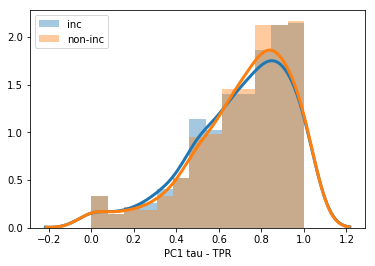

In [105]:
import seaborn as sns

sns.distplot(result5['PC1 incremental - TPR'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'inc')

sns.distplot(result5['PC1 tau - TPR'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'non-inc')
plt.legend()
plt.show()

# Deprecated

In [ ]:
algorithm, stopper, params = 'PCMCI incremental', ICStopper, {'patiency': 2}
col = algorithm + '_bics'

def simulate_stopping(df, stopping, params, col):
    sorted_df = df.sort_values(by='tau estimate')
    idx = stopping.simulate(sorted_df[col].values, **params)
    return sorted_df['tau estimate'].iloc[idx]

agg_se = pd.DataFrame()

for (dim, in_edges, tau, autocorr), res4 in results4.groupby([
    'dimension', 'incoming edges', 'max time lag', 'autocorr']):
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'edges': in_edges, 'autocorr': autocorr}
    
    res3 = results3[(results3[['dimension', 'incoming edges', 'max time lag', 'autocorr'
                                 ]].values == (dim, in_edges, tau, autocorr)).all(axis=1)]
    pred_taus = res3.groupby('run').apply(lambda df: simulate_stopping(df, stopper, params, col))
    pred_errs = [res4[(res4.run == run) & (res4['tau estimate'] == t)][algorithm].iloc[0]
                 for run, t in pred_taus.iteritems()]
    
    df_dict['VAR_tau-1_SE'] = res4[res4['tau estimate'] == tau-1]['complete VAR'].mean() 
    plt.bar(0.2, height=df_dict['VAR_tau-1_SE'], 
            label=r'VAR, $\tau-1$', color='grey', width=0.4)
    df_dict['VAR_tau_SE'] = res4[res4['tau estimate'] == tau]['complete VAR'].mean() 
    plt.bar(0.65, height=df_dict['VAR_tau_SE'], 
            label=r'VAR, $\tau$', color='grey', width=0.4)
    df_dict['VAR_tau+1_SE'] = res4[res4['tau estimate'] == tau+1]['complete VAR'].mean() 
    plt.bar(1.1, height=df_dict['VAR_tau+1_SE'], 
            label=r'VAR, $\tau+1$', color='grey', width=0.4)

    plt.bar(2, height=np.mean(pred_errs), label=algorithm + r', $\hat{\tau}$', width=0.4)
    df_dict[algorithm + '_SE'] = np.mean(pred_errs)
    
    print(df_dict)
    df = pd.DataFrame(df_dict, index=[0])
    agg_se = agg_se.append(df)
    
    plt.ylabel('squared error')
#     plt.yscale('log')
    plt.title(f'tau={tau}, dimensionality={dim}, edge count={in_edges}*dim, autocorr={autocorr}')
    plt.legend()
    plt.show()

### Validate graph

In [ ]:
generator = pickle.load(open(data_path + f't=10_d=3_in=2_autocorr=False_1.pickle', 'rb'))
generator.draw_graph()

In [ ]:
results[(results[['dimension', 'incoming edges', 'max time lag',
                  'autocorr', 'run']].values == (3, 2, 10, False, 1)).all(axis=1)]